<p style="font-size: 36px"><strong>Coding Challenge - Priorization in Lead Generation</strong></p>

by *Julian Dörr*

# Load modules 

In [1]:
from util import plot_describe
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, make_scorer, fbeta_score
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from IPython.display import Markdown as md

# Inspect and clean data

Read data.

In [2]:
df = pd.read_csv('./data/CustomerData_LeadGenerator.csv', sep=',')

Are there any missings?

In [3]:
df.apply(lambda x: x.isnull().sum())

fakeID                                            0
b_specialisation_i                                0
b_specialisation_h                                0
b_specialisation_g                                0
b_specialisation_f                                0
b_specialisation_e                                0
b_specialisation_d                                0
b_specialisation_c                                0
b_specialisation_b                                0
b_specialisation_a                                0
b_specialisation_j                                0
q_OpeningDays                                     0
q_OpeningHours                                    0
q_2017 Average Household Size                     0
q_2017 Total Households                           0
q_2017 HHs: 5th Quintile (68.759 and above)       0
q_5th Quint by Total HH                           0
q_2017 Purchasing Power: Per Capita               0
q_2017 Total Population                           0
q_2017 Pop 1

No missing data.

What are the data types?

In [4]:
df.dtypes

fakeID                                             object
b_specialisation_i                                  int64
b_specialisation_h                                  int64
b_specialisation_g                                  int64
b_specialisation_f                                  int64
b_specialisation_e                                  int64
b_specialisation_d                                  int64
b_specialisation_c                                  int64
b_specialisation_b                                  int64
b_specialisation_a                                  int64
b_specialisation_j                                  int64
q_OpeningDays                                       int64
q_OpeningHours                                     object
q_2017 Average Household Size                     float64
q_2017 Total Households                             int64
q_2017 HHs: 5th Quintile (68.759 and above)         int64
q_5th Quint by Total HH                           float64
q_2017 Purchas

Why is `q_OpeningHours` read as string?

In [5]:
df.q_OpeningHours.value_counts(dropna=False).sort_index(ascending=False)

q_OpeningHours
ject       1
9         12
8         17
7.5        1
7          7
        ... 
11.5       1
11         3
10.5       1
10        17
0       1003
Name: count, Length: 117, dtype: int64

'ject' seems to be a data quality issue. Impute 'ject' by average value of `q_OpeningHours` of obeservations with same `q_OpeningDays`.

In [6]:
# Retrieve q_OpeningDays from observation whose q_OpeningHours equals ject
opening_days_ject = df.loc[df.q_OpeningHours=='ject', 'q_OpeningDays'].values[0]
# Replace ject by NULL
df.loc[df.q_OpeningHours=='ject', 'q_OpeningHours'] = np.nan
# Define 'q_OpeningHours' as float
df['q_OpeningHours'] = df.q_OpeningHours.astype(dtype='float64')
# Impute by average q_OpeningHours of obeservations with same q_OpeningDays
df.loc[df.q_OpeningHours.isnull(), 'q_OpeningHours'] = df.loc[df.q_OpeningDays==opening_days_ject, 'q_OpeningHours'].mean()

Let's visually inspect the data to spot potential outliers or other irregularities.

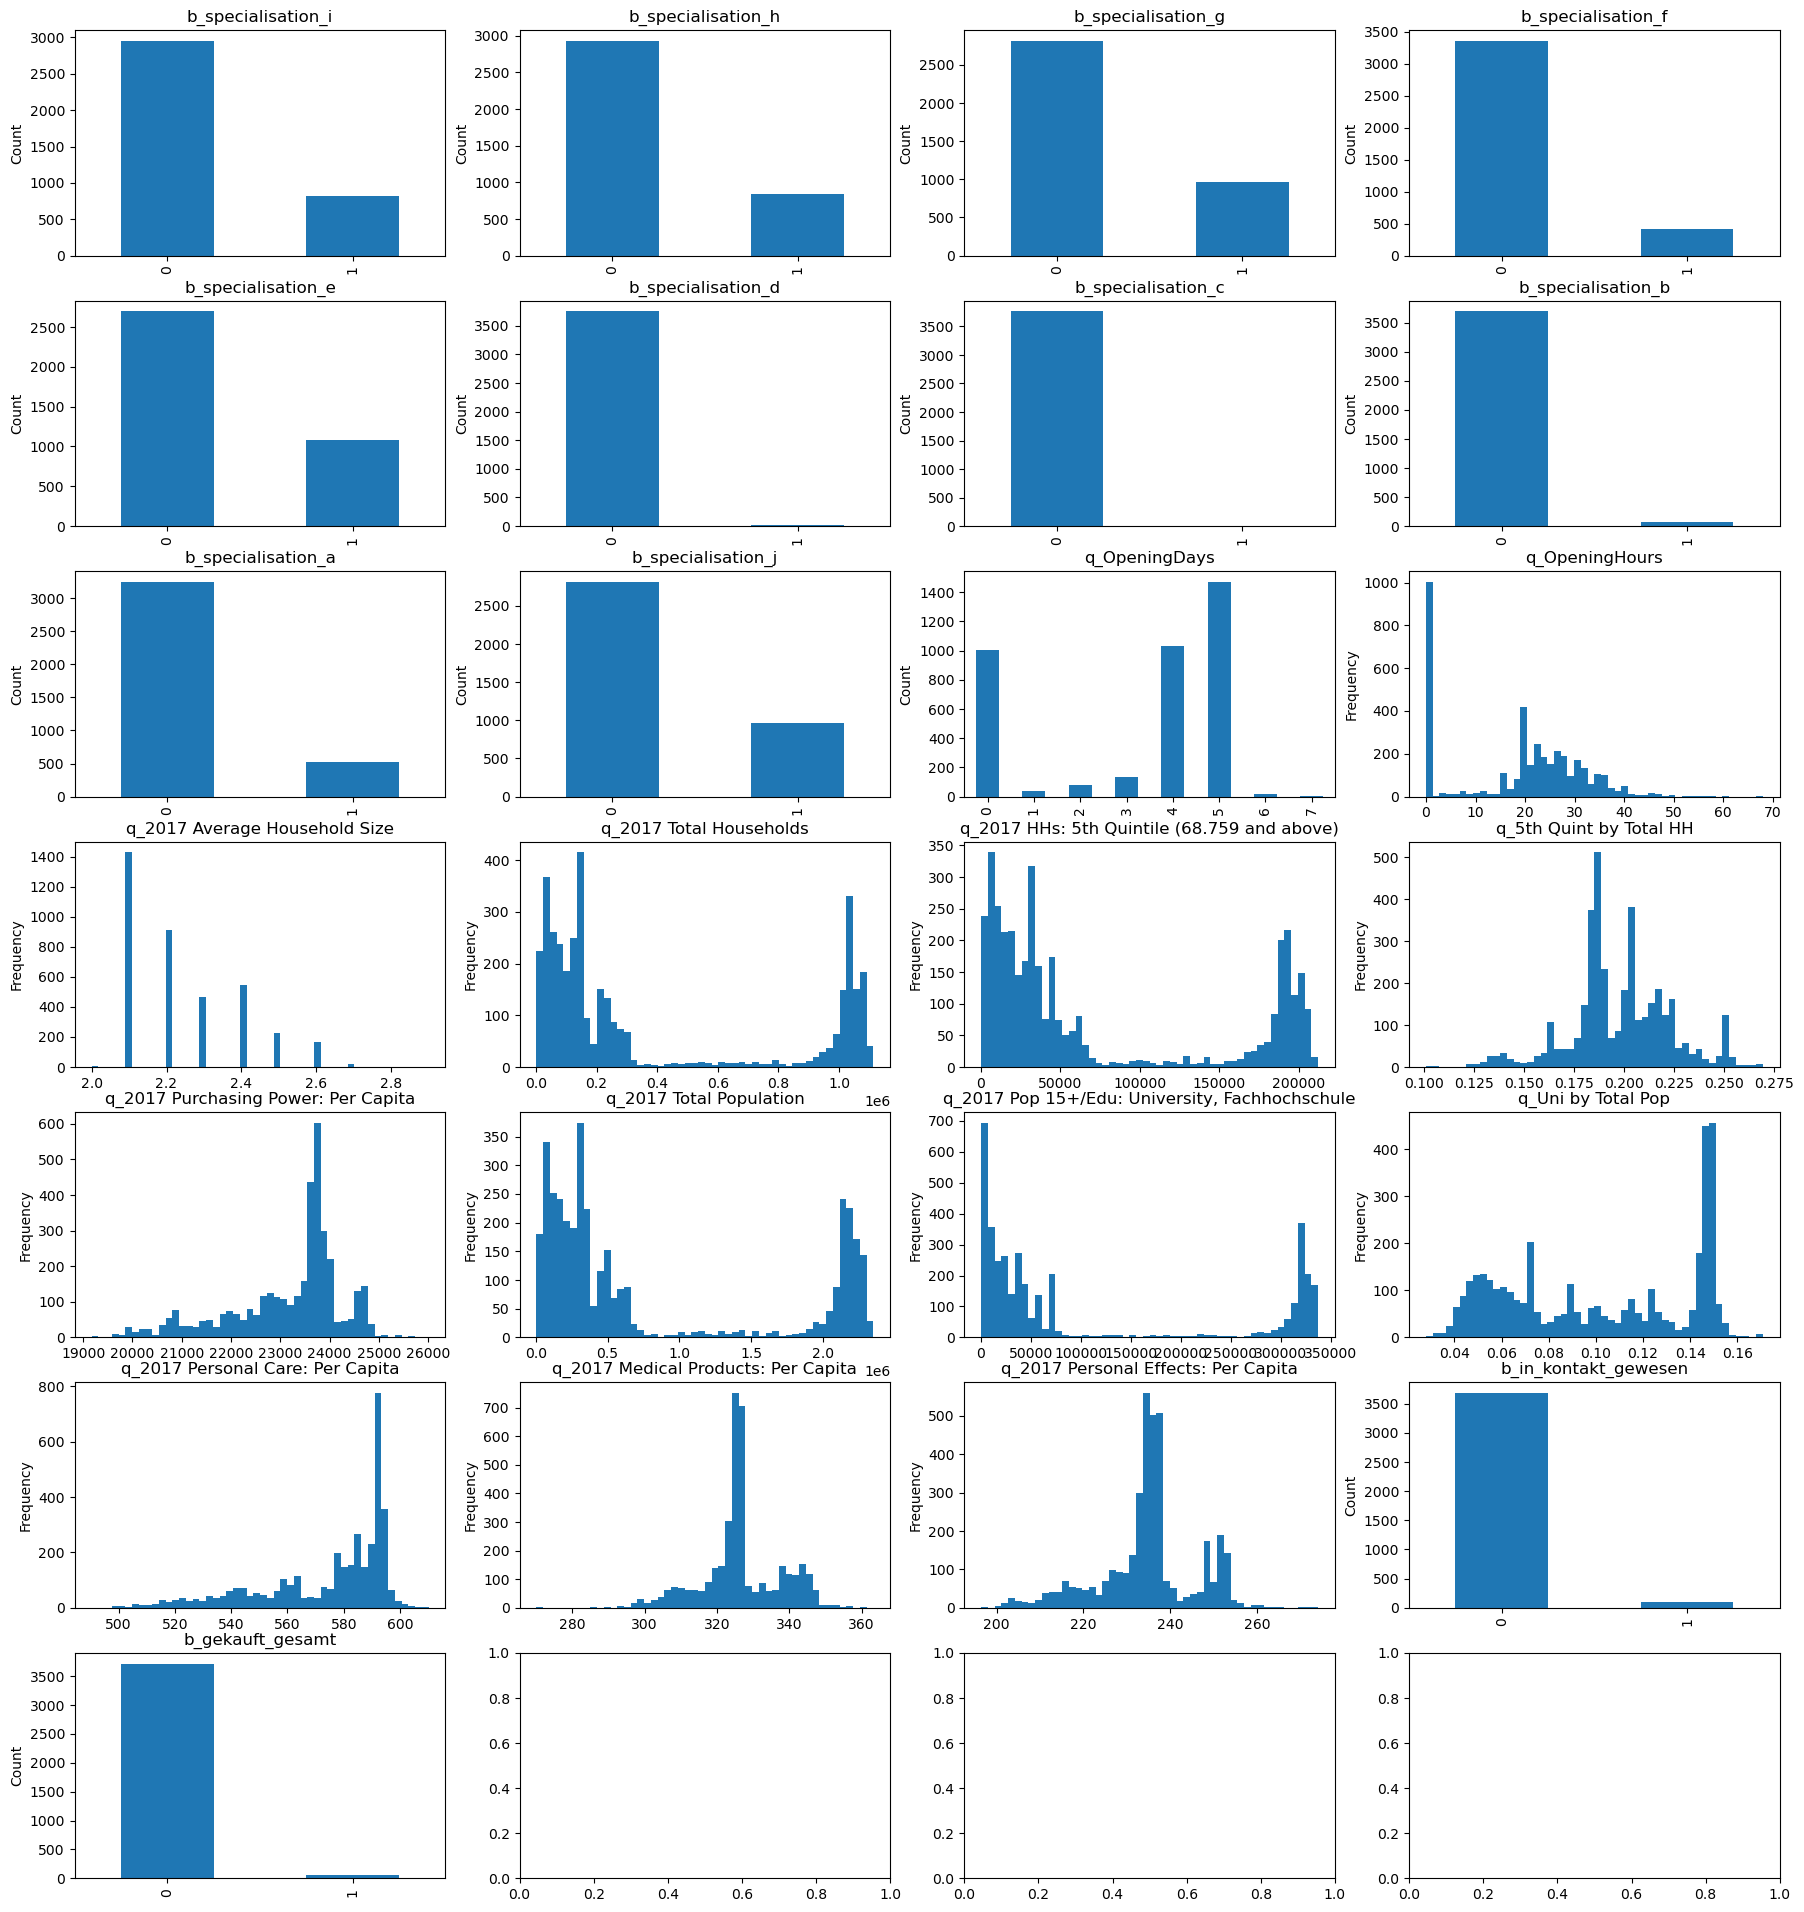

In [7]:
plot_describe(df, columns=df.drop(columns='fakeID').columns)

Some of the specialisation features (`b_specialisation_d`, `b_specialisation_c`, `b_specialisation_b`) as well as `b_in_kontakt_gewesen` and `b_gekauft_gesamt` are highly imbalanced. Also some of the demographic features seem to be bimodal.

Let's understand better what `b_in_kontakt_gewesen` and `b_gekauft_gesamt` represent. How do `b_in_kontakt_gewesen` and `b_gekauft_gesamt` relate to one another in a simple cross table?

In [8]:
pd.crosstab(df['b_gekauft_gesamt'], df['b_in_kontakt_gewesen'], margins=True)

b_in_kontakt_gewesen,0,1,All
b_gekauft_gesamt,,,
0,3678,38,3716
1,0,57,57
All,3678,95,3773


Findings:
- we see that 3.678 observations have not been contacted (treated). None of these have made a purchase
- moreover, we see that 95 observations have been contacted. 57 of those which have been contacted made a purchase
- at first, this signals that generating leads (get in touch with potential customers), is a strong predictor for an ultimate purchase
- this raises the question which potential customers to prioritize in lead generation?

# Project formulation

To tackle this question we aim at developing a classification model that allows to predict how likely it is that a potential customer makes a purchase if he/she has been contacted before based on the potential customer's demographics (features). In other words, how can resources (contacting potential customers) be spent most efficiently.
For this purpose, we
- drop `b_in_kontakt_gewesen` as feature since this information will not be available at inference 
- try to understand which customer features drive the purchase decision
- develop a first predictive model which serves as POC for an automated priorization in lead generation

## Feature engineering

To get a first idea how the decision whether to contact a potential customer or not is made we check whether the treatment has been assigned randomly to the potential customers or whether there is a certain selection in which potential customers to contact based on the customer's features.

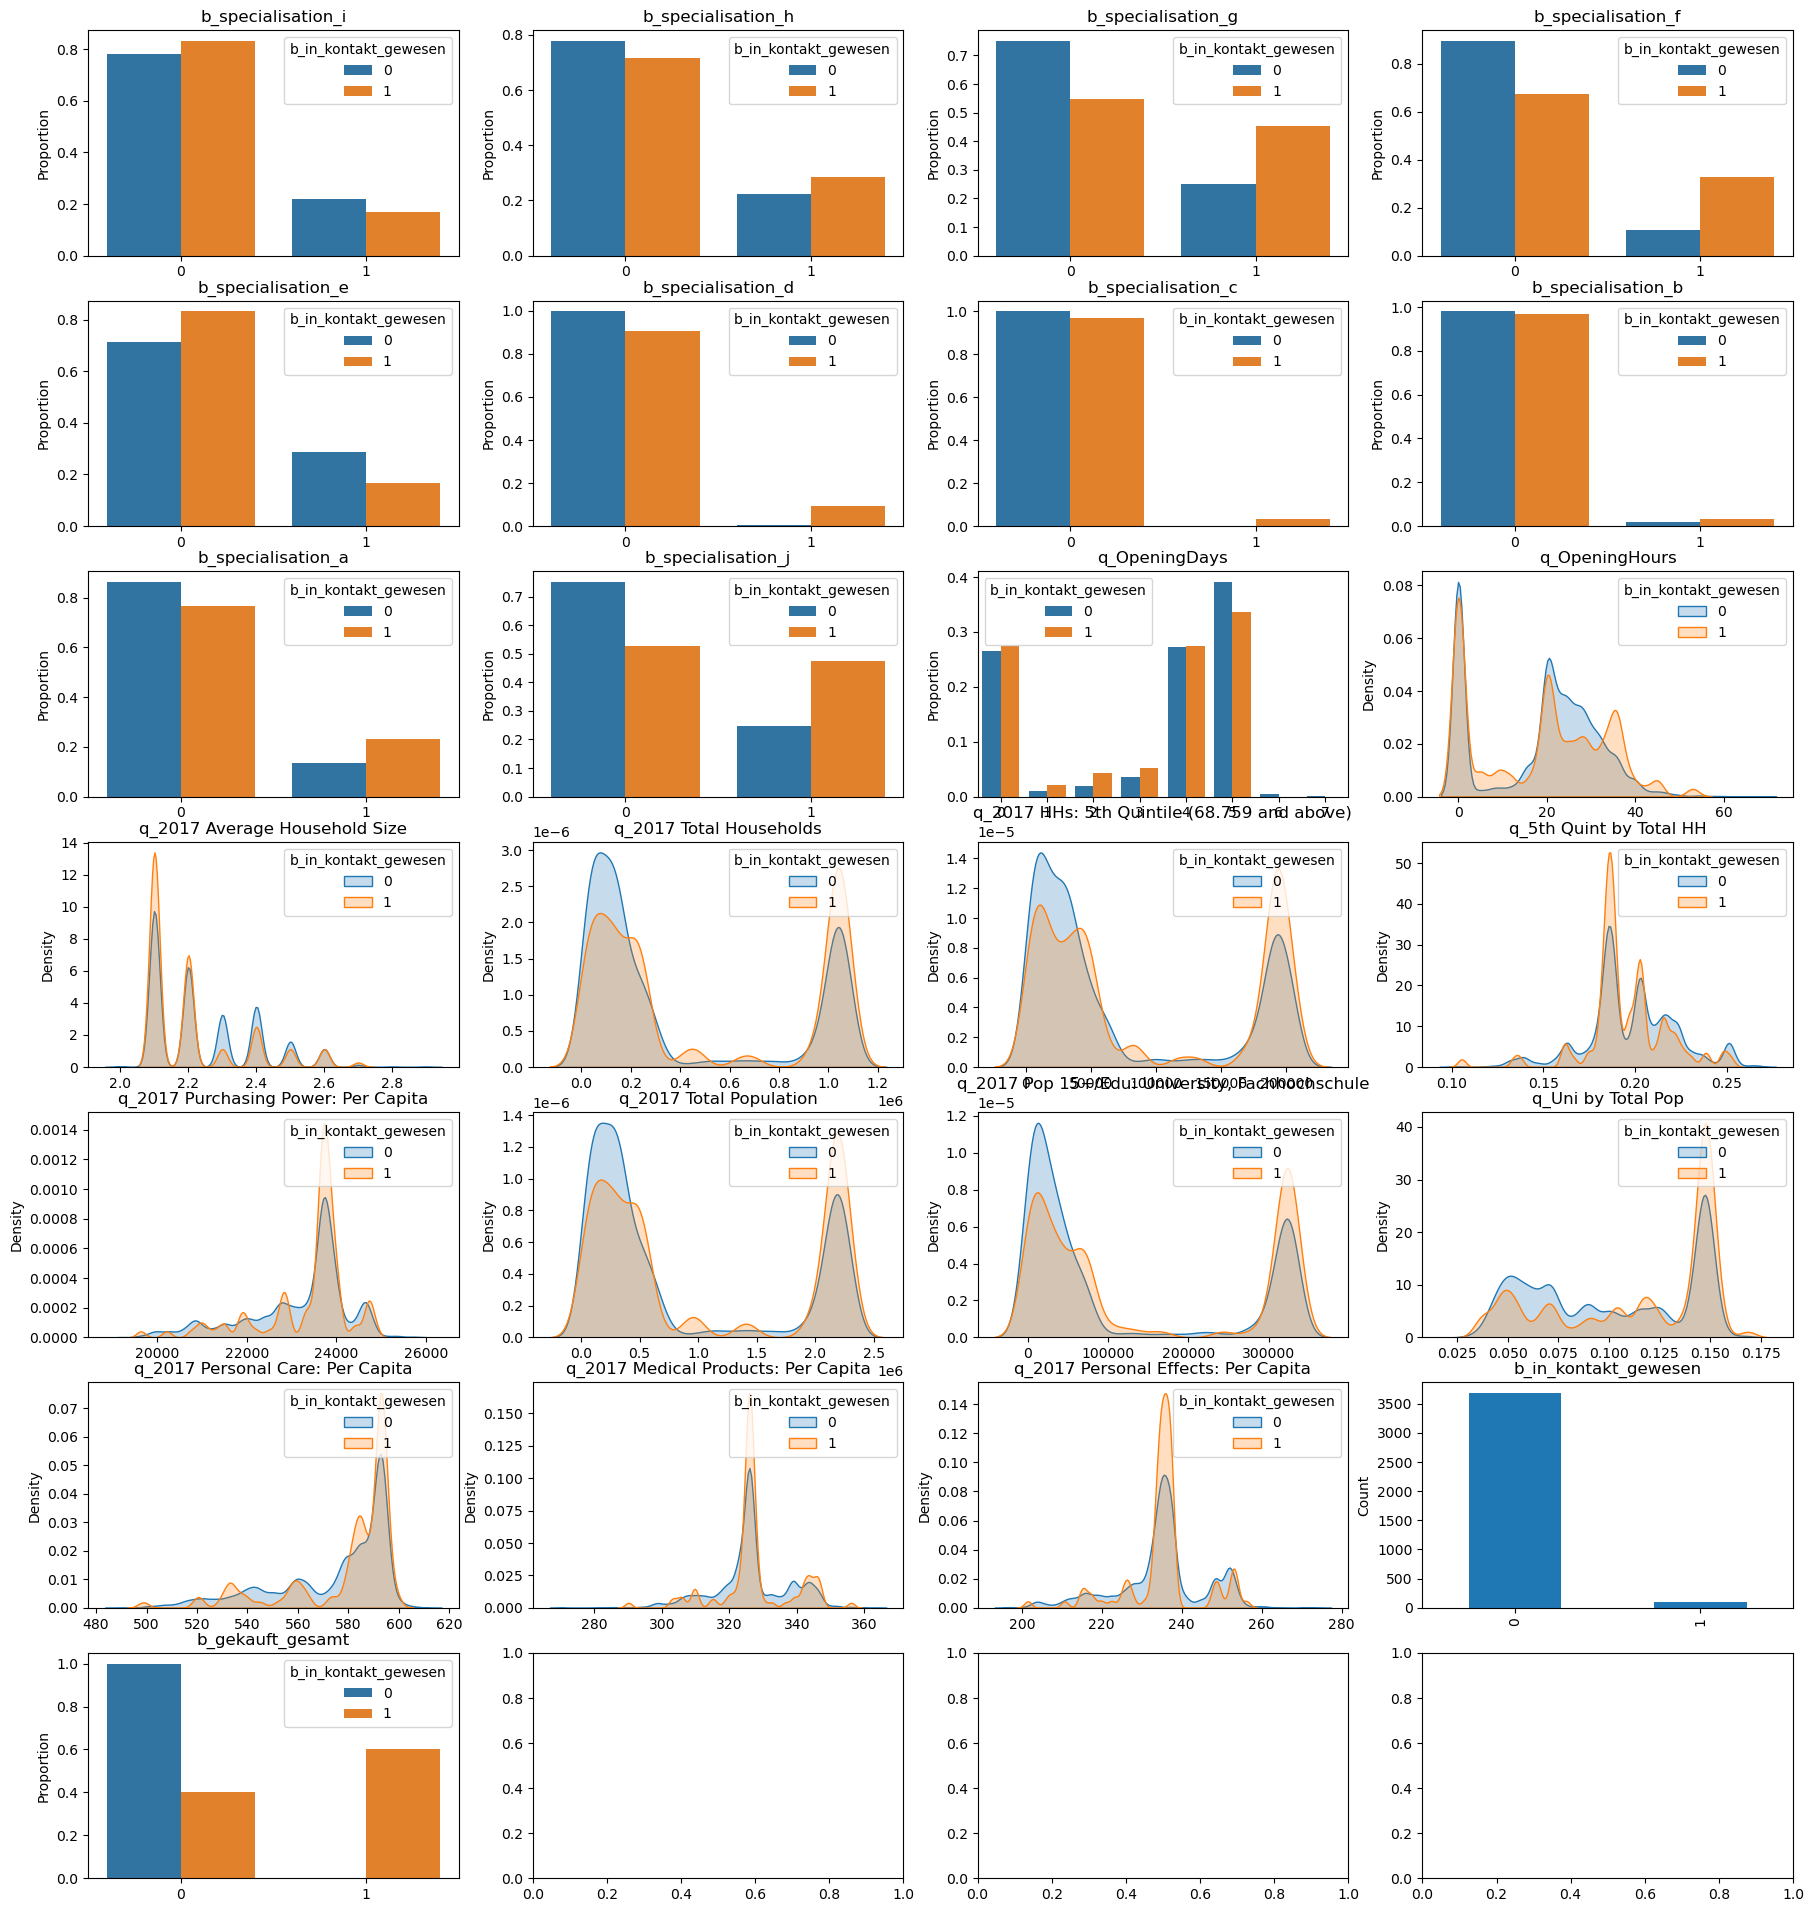

In [9]:
plot_describe(df, columns=df.drop(columns='fakeID').columns, hue='b_in_kontakt_gewesen')

Based on the visual inspection I assume that contacting potential customers happens at random (at least based on the provided features) since the distribution of the features across treated and non-treated observations looks quite similar for all features.

In [10]:
pd.concat([
    pd.crosstab(df['b_gekauft_gesamt'], df['b_in_kontakt_gewesen'], margins=True, normalize=False, dropna=False),
    pd.crosstab(df['b_gekauft_gesamt'], df['b_in_kontakt_gewesen'], margins=True, normalize=True, dropna=False).round(decimals=2)
])

b_in_kontakt_gewesen,0,1,All
b_gekauft_gesamt,,,
0,3678.00,38.00,3716.00
1,0.00,57.00,57.00
All,3678.00,95.00,3773.00
0,0.97,0.01,0.98
1,0.00,0.02,0.02
All,0.97,0.03,1.00


We have a relatively small sample of 3,773 observations that is highly imbalanced in its target variable `b_gekauft_gesamt` with only 2% having a positive label. There are 26 - `fakeID` - `b_in_kontakt_gewesen` - `b_gekauft_gesamt` = 23 potential predictors (features) at hand. Let's take a closer look at the potential features.

In [11]:
df.head().style

,fakeID,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,q_OpeningDays,q_OpeningHours,q_2017 Average Household Size,q_2017 Total Households,q_2017 HHs: 5th Quintile (68.759 and above),q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_in_kontakt_gewesen,b_gekauft_gesamt
0,1069_7334,0,0,0,0,0,0,0,0,0,1,4,36.000000,2.100000,1045481,195228,0.186735,23730.350000,2194057,324656,0.147971,593.190000,326.280000,235.750000,1,1
1,328_2350,0,0,0,1,1,1,0,0,0,0,4,20.000000,2.100000,935739,168291,0.179848,23343.260000,1966798,281130,0.142938,588.540000,320.360000,230.660000,1,1
2,865_6285,0,0,0,1,0,1,0,0,0,1,0,0.000000,2.100000,1026235,189787,0.184935,23674.180000,2149624,320326,0.149015,592.880000,325.570000,234.820000,1,1
3,47_307,0,1,1,0,0,0,0,0,0,0,4,20.000000,2.100000,1027701,189634,0.184523,23572.260000,2161445,310981,0.143876,590.840000,324.060000,233.810000,1,0
4,342_2513,0,0,0,0,0,1,0,0,0,1,5,33.000000,2.100000,1093324,207590,0.189871,23821.630000,2302959,334940,0.145439,593.560000,327.750000,237.410000,1,1


Looking at the column names and the respective values, I am going to make the following assumptions (clearly, for a business case these need to be closely aligned with the process owning department):
- we have a sample of commercial customers
- we have information on the commercial customer's business (`b_specialisation_*`, `q_Opening*`) and demographic information of the commercial customer's geographic location (`q_2017*`, `q_5th*`, ...)
- for the geographic features it seems reasonable to consider relative measures in the first place (i.e. `q_5th Quint by Total HH`, `q_Uni by Total Pop` and `*:Per Capita`)
- I also consider `q_2017 Total Households` to understand whether the mere size of the geographic region has a high predictive power on purchases

In [13]:
df = df.drop(columns=['b_in_kontakt_gewesen', 'q_2017 HHs: 5th Quintile (68.759 and above)', 'q_2017 Pop 15+/Edu: University, Fachhochschule', 'q_2017 Total Population'])

<Axes: >

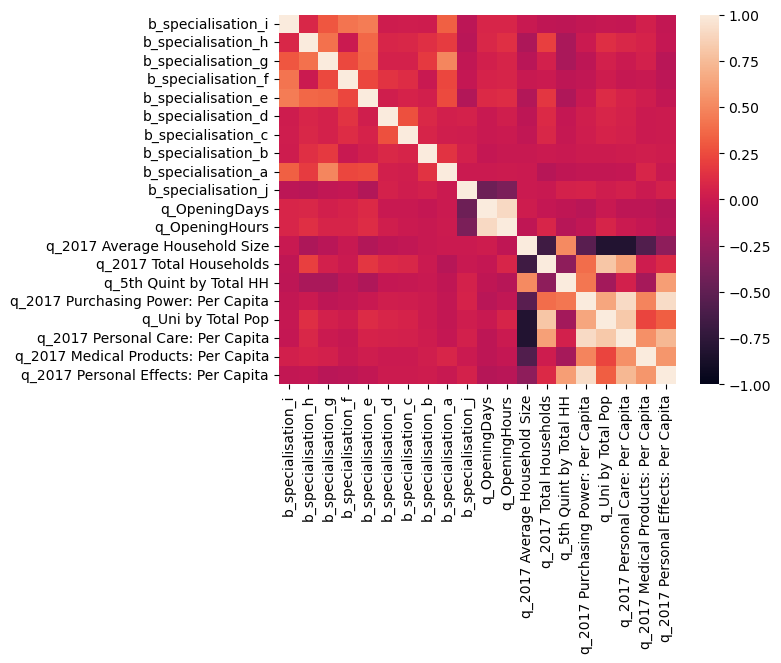

In [14]:
sns.heatmap(df.drop(columns=['fakeID', 'b_gekauft_gesamt']).corr(), vmin=-1, vmax=1)

Caution: `q_2017 Average Household Size` is strongly correlated with some of the other geographic features (e.g. `q_Uni by Total Pop`, `q_2017 Personal Care: Per Capita`).

## Which features drive the purchase decision?

To answer this question we choose a logistic regression. First of all, this allows us to judge whether the influence of the selected features are statistically significant. Given the small sample size this important to consider especially when aiming at the development of a predictive model for the priorization of customers in lead generation. If we find on the small sample statistically significant correlations between certain features and the target variable, we can be more confident in developing a model that is tuned for out-of-sample prediction. Note, for this first step I do not do a split into training and test sets but rather focus on the statistical significance therefore trying to get the most out of the small sample size.

In [15]:
X = df.drop(columns=['fakeID', 'b_gekauft_gesamt'])
y = df['b_gekauft_gesamt']

In [16]:
# Add a constant column to the predictor variables for statsmodels
X = sm.add_constant(X)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y, X)
results = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.064006
         Iterations 10


In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       b_gekauft_gesamt   No. Observations:                 3773
Model:                          Logit   Df Residuals:                     3752
Method:                           MLE   Df Model:                           20
Date:                Sat, 03 Feb 2024   Pseudo R-squ.:                  0.1829
Time:                        18:17:52   Log-Likelihood:                -241.50
converged:                       True   LL-Null:                       -295.54
Covariance Type:            nonrobust   LLR p-value:                 4.361e-14
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                -121.1737     39.822     -3.043      0.002    -199.223     -43.125
b_specialisation_i                     -0.8013      0.462     -1.735      0.083      -1.706       0.104
b_specialisation_h                     -0.2113      0.401     -0.527      0.598      -0.997       0.575
b_specialisation_g                      0.6217      0.377      1.649      0.099      -0.117       1.361
b_specialisation_f                      1.7100      0.380      4.497      0.000       0.965       2.455
b_specialisation_e                     -1.4591      0.467     -3.121      0.002      -2.375      -0.543
b_specialisation_d                      2.6684      0.628      4.247      0.000       1.437       3.900
b_specialisation_c                     -0.9832      1.253     -0.785      0.433      -3.438       1.472
b_specialisation_b                      0.4164      0.716      0.581      0.561      -0.987       1.820
b_specialisation_a                      0.2375      0.439      0.541      0.589      -0.623       1.098
b_specialisation_j                      0.9073      0.335      2.712      0.007       0.252       1.563
q_OpeningDays                          -0.0063      0.180     -0.035      0.972      -0.358       0.346
q_OpeningHours                          0.0076      0.025      0.301      0.764      -0.042       0.057
q_2017 Average Household Size          21.7171      6.851      3.170      0.002       8.289      35.145
q_2017 Total Households              2.038e-07   7.38e-07      0.276      0.783   -1.24e-06    1.65e-06
q_5th Quint by Total HH               -22.4167     48.578     -0.461      0.644    -117.628      72.795
q_2017 Purchasing Power: Per Capita    -0.0012      0.002     -0.682      0.495      -0.005       0.002
q_Uni by Total Pop                     29.3691     16.300      1.802      0.072      -2.579      61.317
q_2017 Personal Care: Per Capita        0.1498      0.077      1.951      0.051      -0.001       0.300
q_2017 Medical Products: Per Capita     0.0867      0.069      1.261      0.207      -0.048       0.222
q_2017 Personal Effects: Per Capita    -0.0722      0.189     -0.382      0.703      -0.443       0.298
=======================================================================================================
"""

We see that some features show a statistically significant correlation with the target variable (`b_specialisation_d:f`, `b_specialisation_j`, `q_2017 Average Household Size`, `q_Uni by Total Pop`, `q_2017 Personal Care: Per Capita`) which seems also to be supported by the simple visualization below (discrimination in target variable by these features). This gives a first hint that developing a predictive model based on potential customer's features may be a succesful endavour for coming up with an automated priorization in lead generation. Nonetheless, the majority of features shows no statistically significant correlation with the target, so let us see whether we can develop a classifier capable of reliably distinguishing potential customers who make a purchase and those wo do not make a purchase.

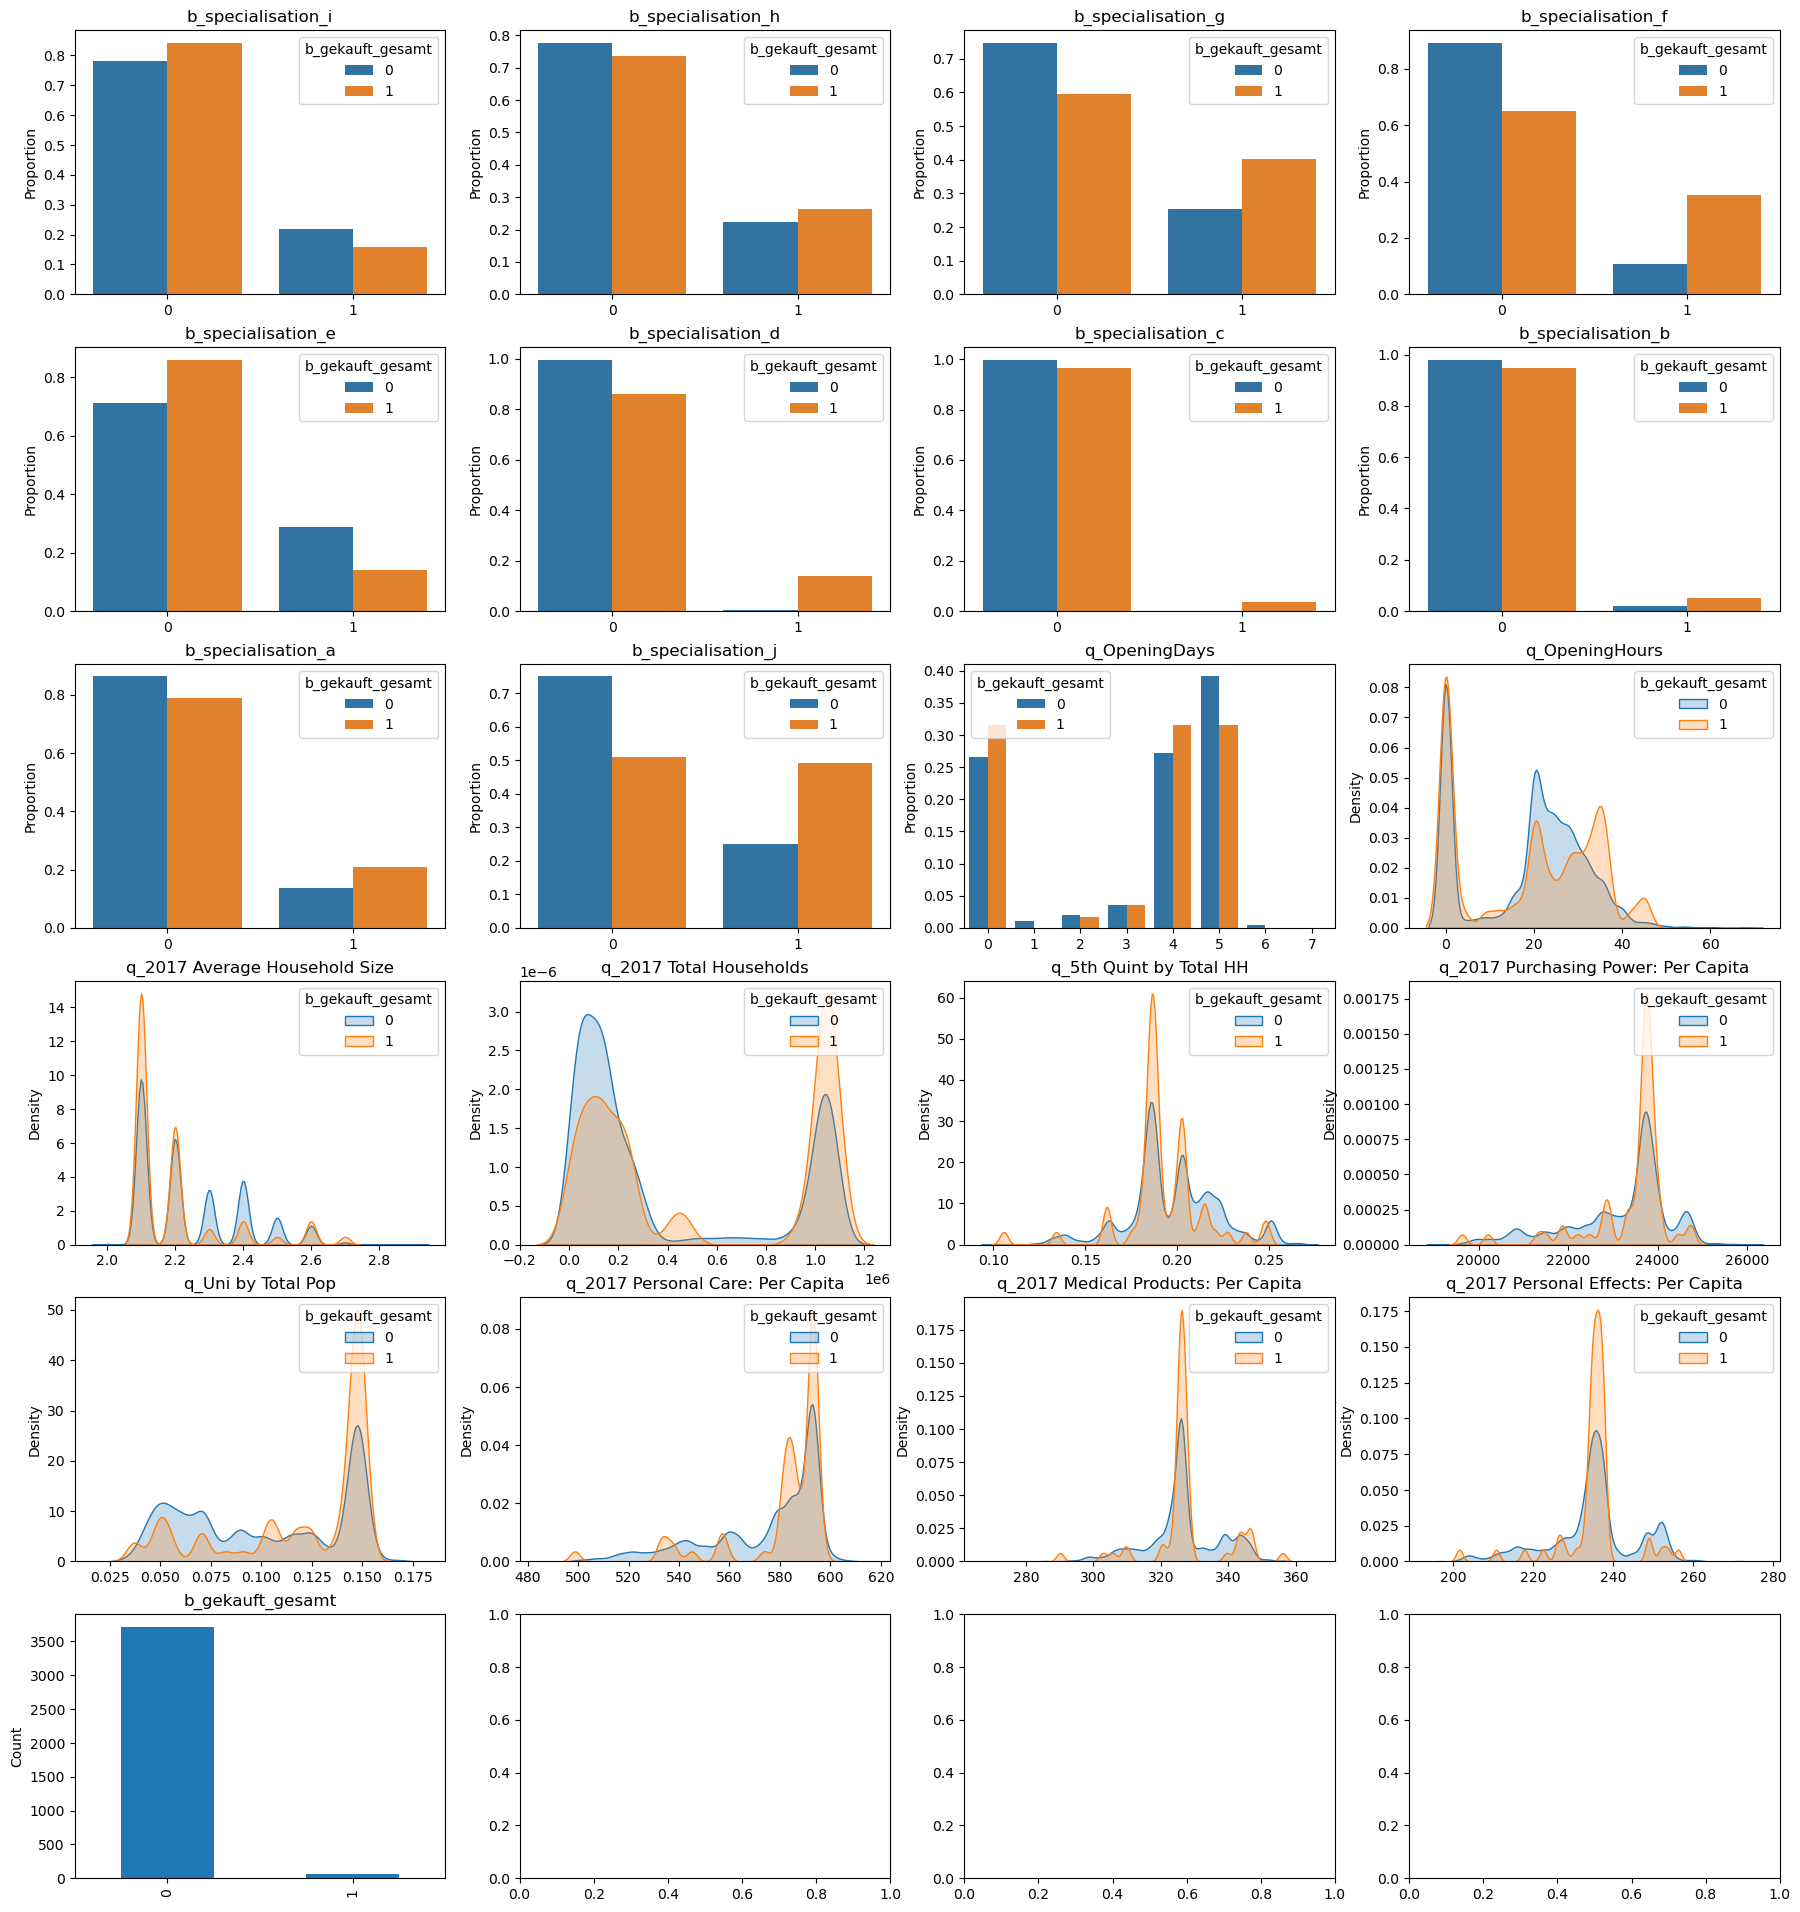

In [18]:
plot_describe(df, columns=df.drop(columns=['fakeID']).columns, hue='b_gekauft_gesamt')

## Develop a classifier

This classifier shall serve the purpose of indicating the propability of a potential customer to make a purchase. The major challenge will be to train a model that can handle the imbalanced data set. To tackle this issue we try oversampling the minority group in the training data. For this purpose we use a Synthetic Minority Over-Sampling Technique ([SMOTE](https://arxiv.org/abs/1106.1813)) approach.

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

In [20]:
# Oversampling minority group via SMOTE
X_train_resampled, y_train_resampled = SMOTE(
    sampling_strategy=1/10, # ratio between minority group and majority group representations in resampled training data
    random_state=333).fit_resample(X_train, y_train)

In [21]:
md(f"The original training/test set contains {round(y_train.sum()/len(y_train)*100,2)}%/{round(y_test.sum()/len(y_test)*100,2)} % of positive labels in the target variable. The resampled training set contains {round(y_train_resampled.sum()/len(y_train_resampled)*100,0)}% of positive labels in the target variable.")

The original training/test set contains 1.52%/1.46 % of positive labels in the target variable. The resampled training set contains 9.0% of positive labels in the target variable.

In the following, we train four commonly used ML classification models for the purpose of testing whether the priorization of lead generation can be automated via a predictive model which reliably indicates which potential customers have a higher/lower probability to make purchases based on their features that are typically known at inferece. Our setup is as follows:
- for the sake of comparability we train on both the oversampled and the original training data
- we aim at approximating the best set of hyperparameters on validation sets using cross-validation in order to prevent overfitting
- we focus on optimizing the F1-Score for the minority group. In other words, our goal is to create a classification model that performs well in identifying the maximum number of potential customers who have made a purchase (Recall), while also ensuring that the potential customers predicted as having made a purchase actually have made a purchase (Precision).
- for scale sensitive models (Support Vector Machine) we scale the features by substracting their mean and dividing by their standard deviation

In [22]:
# Define scoring metric
fscore_purchase = make_scorer(
    score_func=fbeta_score, 
    beta=1,                 # equal weight on Precision and Recall
    average='binary',       # target minority group
    pos_label=1             # minority group takes on the value of 1 (purchase)
    )       

# Define the pipeline for each model
pipelines = [
    ('logistic_regression', Pipeline([
        ('model', LogisticRegression(max_iter=400))
    ])),
    ('random_forest', Pipeline([
        ('model', RandomForestClassifier())
    ])),
    ('gradient_boosting', Pipeline([
        ('model', GradientBoostingClassifier(random_state=333))
    ])),
    ('support_vector_machine', Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC())
    ]))
]

# Define the hyperparameter grid for each model
hyperparameters = {
    'logistic_regression': {
        'model__penalty': [None, 'l2']
    },
    'random_forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 2, 5, 10],
        'model__min_samples_leaf': [1, 2, 5],
        
    },
    'gradient_boosting': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0,1, 0.5,],
        'model__max_depth': [2, 3, 4]
    },
    'support_vector_machine': {
        'model__C': [0.1, 1, 10, 20, 50],
        'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'model__degree': [2, 3, 4]
        
    }
}

Train the models given the different hyperparameter constellations and store the average F1-Score on the validation folds for later comparison.

In [23]:
# Create empty df for saving the grid search results
df_model = pd.DataFrame(columns=['MODEL', 'SAMPLING', 'PARAMS', 'MEAN_SCORE'])

# Perform grid search for each model
for model_name, pipeline in tqdm(pipelines):
    # Conduct training on both original and oversampled training set
    for strategy, sample in [('No oversampling', (X_train, y_train)), ('Oversampling', (X_train_resampled, y_train_resampled))]:
        grid_search = GridSearchCV(pipeline, hyperparameters[model_name], cv=3, scoring=fscore_purchase)
        grid_search.fit(sample[0], sample[1])
        df_model = pd.concat([df_model, pd.DataFrame({
            'MODEL': model_name, 
            'SAMPLING': strategy,
            'PARAMS': grid_search.cv_results_['params'], 
            'MEAN_SCORE': grid_search.cv_results_['mean_test_score']})])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [12:29<00:00, 187.47s/it]


For each model look at the best performing specification on the original validation sets and the oversampled validation sets.

In [24]:
df_model.sort_values('MEAN_SCORE', ascending=False).groupby(['MODEL', 'SAMPLING']).head(1).sort_values('MODEL')

,MODEL,SAMPLING,PARAMS,MEAN_SCORE
35,gradient_boosting,Oversampling,"{'model__learning_rate': 0.5, 'model__max_dept...",0.723145
21,gradient_boosting,No oversampling,"{'model__learning_rate': 1, 'model__max_depth'...",0.174576
1,logistic_regression,No oversampling,{'model__penalty': 'l2'},0.000000
0,logistic_regression,Oversampling,{'model__penalty': None},0.000000
2,random_forest,Oversampling,"{'model__max_depth': None, 'model__min_samples...",0.694854
20,random_forest,No oversampling,"{'model__max_depth': 5, 'model__min_samples_le...",0.000000
53,support_vector_machine,Oversampling,"{'model__C': 50, 'model__degree': 3, 'model__k...",0.573151
38,support_vector_machine,No oversampling,"{'model__C': 20, 'model__degree': 2, 'model__k...",0.182776


In [25]:
md(f"The best performing model is a {df_model.sort_values('MEAN_SCORE', ascending=False).iloc[0].MODEL} with an average F1-Score of {round(df_model.sort_values('MEAN_SCORE', ascending=False).iloc[0].MEAN_SCORE*100,2)}% on the validation folds. Little surprisingly, oversampling strongly helps the model to learn from the minority group since for all models (except Logistic Regression) the performance is best when being trained on the oversampled training data. The crucial question is how well the best performing model performs when being confronted with the real-world distribution of the target variable. For this purpose, we test the best model's performance on the test set.")

The best performing model is a gradient_boosting with an average F1-Score of 72.31% on the validation folds. Little surprisingly, oversampling strongly helps the model to learn from the minority group since for all models the performance is best when being trained on the oversampled training data. The crucial question is how well the best performing model performs when being confronted with the real-world distribution of the target variable. For this purpose, we test the best model's performance on the test set.

In [26]:
# Define the best performing model
pipeline = Pipeline(steps=[
    ('best_model', GradientBoostingClassifier(learning_rate=1, max_depth=4, n_estimators=300))
])

# Train on the entire oversampled training data
pipeline.fit(X_train_resampled, y_train_resampled)

# Make predictions for the test observations
y_pred = pipeline.predict(X_test)

# Return performance metrics
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       744
           1       0.09      0.18      0.12        11

    accuracy                           0.96       755
   macro avg       0.54      0.58      0.55       755
weighted avg       0.97      0.96      0.97       755



We can see that the best performing model does not generalize well:
- from the 11 positive labels (potential customer made purchase) in the test data only 2 have been detected by the classifier (Recall = 2/11 = 0.18)
- for 23 potential customers in the test data the classifier has predicted that they make a purchase. Only 2 of them have indeed made a purchase (Precision = 2/23 = 0.09)

This means that when the classifier is confronted with the real distribution of target variable it does not help in reliably identifying those potential customers which end up making a purchase.

These results come with many caveats:
- zero knowledge about the actual business case, i.e. no exchange with process-owning unit, no information on how lead contacting is currently undertaken etc.
- little knowledge about the features
- results derived under severe time constraints

In a real-world scenario I would undergo the following next steps:
- get in close exchange with business unit trying to better understand the underlying process
- gather additonal observations and/or features if possible
- spend more time on understanding/engineering features
- implement further approaches to handle imbalanced data